In [1]:
import torch

In [2]:
%run ./ch03_Part_A.ipynb

torch version: 2.1.2
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
tensor(0.9544)
tensor(0.9544)
Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565]

# Chapter 3: Coding Attention Mechanisms - Part B

# 3.5 Hiding future words with causal attention

### Causal Attention Overview:
- **Causal attention** is a form of self-attention that limits the model to only consider previous and current tokens in a sequence.
- This is different from **standard self-attention**, which allows access to the entire input sequence simultaneously.
- In simpler words, this ensures that each next word prediction should only depend on the preceding words.

### Attention Score Calculation:
- The causal attention mechanism ensures the model only considers tokens up to and including the current one.
- **Attention weights** are masked above the diagonal to prevent access to future tokens.
- The non-masked attention weights are then normalized, ensuring they sum to 1 per row.

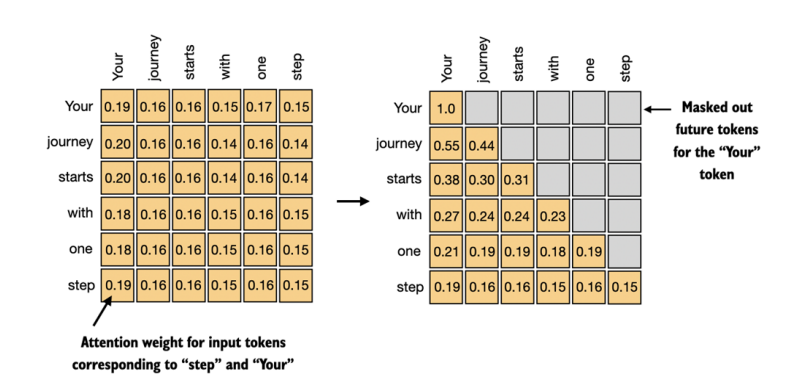

## 3.5.1 Applying a causal attention mask

### Attention Weights Calculation:
- The initial attention weights are calculated using the **softmax function**, as done in prior sections.

### Masking Process:
- A mask is created using PyTorch's `tril` function to zero out all values above the diagonal, preventing attention to future tokens.
- This mask is then applied to the attention weights to remove these values above the diagonal:
    - Multiply the attention weights with this mask to zero out the attention scores above the diagonal

### Renormalization:
- The masked attention weights are then renormalized so that each row sums to 1.
- This is done by dividing each element by the sum of all non-zero elements in its row.

### Final Result:
- The resulting attention weight matrix only allows attention to tokens up to the current one, with all rows summing to 1.


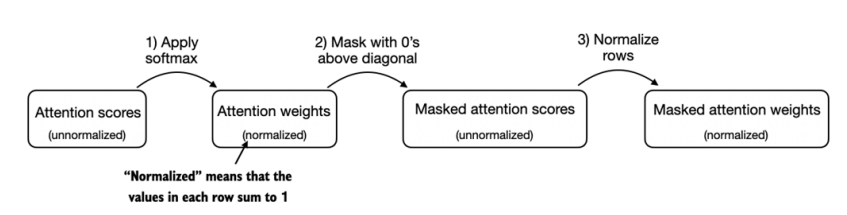

#### Note: Here the attention scores and weights from the previous section are used 

In [3]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [4]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [5]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


- Original
- However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax
- Softmax ensures that all output values sum to 1
- Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects

- - Original
- To make sure that the rows sum to 1, we can normalize the attention weights as follows:

In [6]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


### Optimized Masking:
- Instead of explicitly zeroing out values above the diagonal and renormalizing, the technique maskS the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function, ensuring softmax treats them as zero probability (since 𝑒^{-∞} ≈ 0).

### Application of Softmax:
- Applying the **softmax function** to this masked matrix directly produces a normalized probability distribution where each row sums to 1, eliminating the need for further normalization.

### Efficient Context Vector Calculation:
- The modified attention weights can then be used to compute **context vectors** efficiently.


**This trick allows the model to implement causal attention more efficiently in fewer steps.**


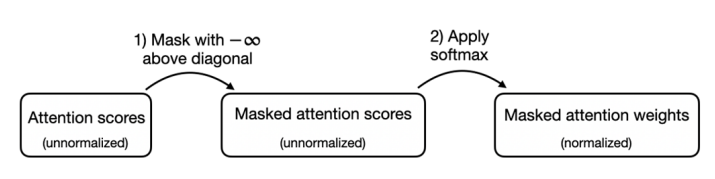

In [7]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [8]:
attn_scores

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)

In [9]:
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [10]:
mask.bool()

tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

- As we can see below, now the attention weights in each row correctly sum to 1 again:

In [13]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


### Further Improvements:
- Here we describe another tweak to reduce overfitting during training, offering additional improvements to the causal attention mechanism.

# 3.5.2 Masking additional attention weights with dropout

### Dropout Basics:
- **Dropout** is a technique where random hidden layer units are ignored or "dropped" during training to prevent overfitting, ensuring the model doesn't over-rely on specific units.
- Dropout is only applied during training and is turned off during inference.

### Application in Attention Mechanism:
- In transformers, dropout is typically used after calculating attention scores or after applying the attention weights to the value vectors.
- Using dropout after computing attention weights is more common which is used here.

### Dropout Rate:
- The example uses a **dropout rate** of 50%, meaning half of the attention weights are randomly set to zero.
- To balance the reduction in active weights, the remaining weights are scaled up by a factor of 2 (1/0.5).
- To train the GPT model later, a lower dropout rate, such as 0.1 or 0.2, wil be used


### Effect on Attention Weights:
- After applying dropout, some weights are zeroed out, and the remaining weights are rescaled.
- This ensures the attention mechanism remains consistent during training and inference.

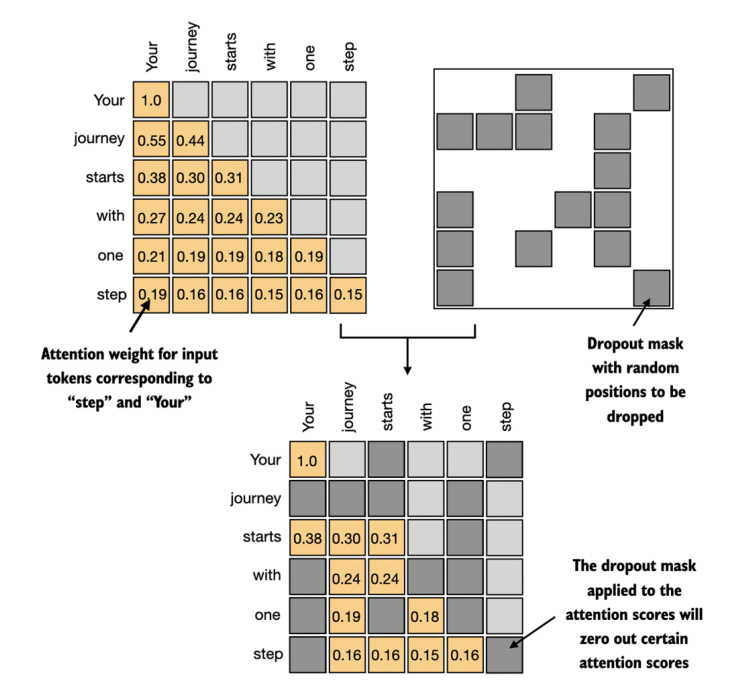

In [14]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [15]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


### Next Step:
- A Python class will be developed to facilitate efficient application of causal attention and dropout in the following section.


## 3.5.3 Implementing a compact causal self-attention class

### Causal Attention Class:
- The new **CausalAttention** class will incorporate causal attention and dropout features into the existing **SelfAttention** class, preparing for multi-head attention implementation in the upcoming section.

### Batch Support:
- The new class will support batch processing as it uses data loaders, ensuring compatibility with the output from previous data-loading components.

### PyTorch Buffers:
- The class utilizes `self.register_buffer()` to handle device management automatically. This ensures that tensors are moved to the correct device (CPU or GPU) without manual intervention.

### Usage:
- The **CausalAttention** class is used similarly to the **SelfAttention** class but now includes dropout and causal masking.

### Next Steps:
- The following section will build upon this by implementing a **multi-head attention** module, leveraging parallel causal attention mechanisms.


- Now, we are ready to implement a working implementation of self-attention, including the causal and dropout masks
- One more thing is to implement the code to handle batches consisting of more than one input so that our `CausalAttention` class supports the batch outputs produced by the data loader we implemented in chapter 2
- For simplicity, to simulate such batch input, we duplicate the input text example:

In [16]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [17]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


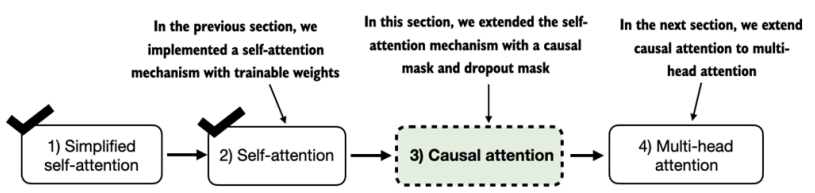

## 3.6 Extending single-head attention to multi-head attention

### Definition of Multi-Head Attention:
- **Multi-head attention** divides the attention mechanism into separate "heads," each with its own weights that independently process the input sequence.

### Stacking Approach:
- The first approach to multi-head attention is to stack multiple instances of the single-head **causal attention** class to build a comprehensive multi-head module.
- Each instance is called a **head**, and they process inputs sequentially.

### Parallel Processing:
- The **MultiHeadAttentionWrapper** class stacks multiple heads and produces context vectors by processing input data (queries, keys, and values) through each head.
- The outputs of all heads are then combined into a higher-dimensional context vector.

## 3.6.1 Stacking multiple single-head attention layers

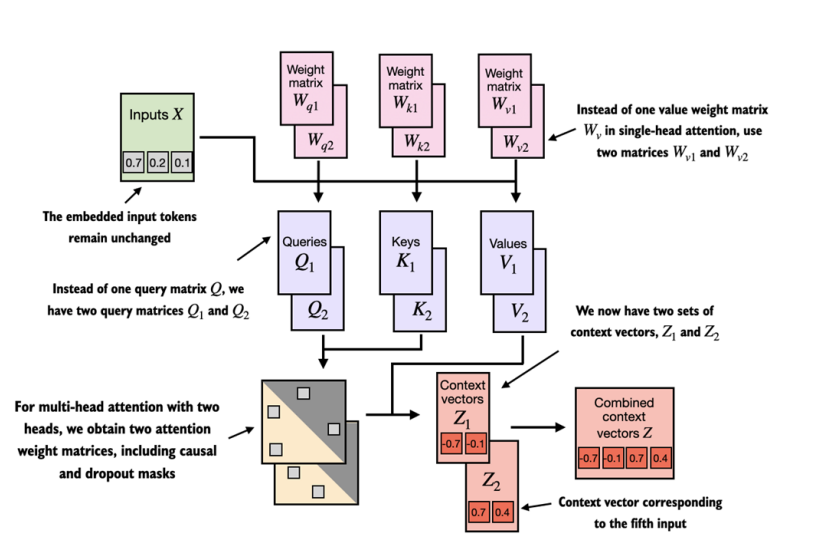

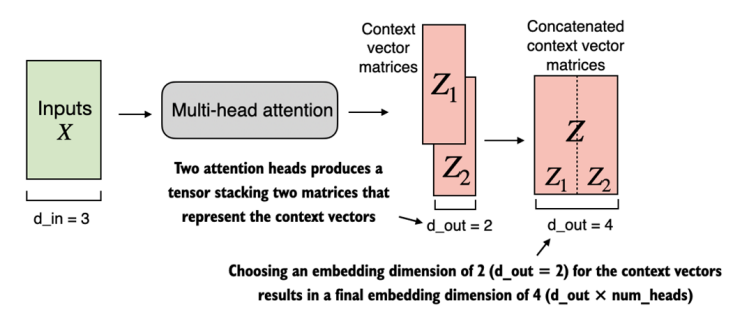

In [18]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


- In the implementation above, the embedding dimension is 4, because we `d_out=2` as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

### Optimization in Parallel:
- The current implementation processes each head sequentially, which could be inefficient.
- A more optimized approach would involve processing heads in parallel through matrix multiplication, which the following section will explore.


## 3.6.2 Implementing multi-head attention with weight splits

### Integrated Implementation:
- Combines multi-head functionality into one class by reshaping and splitting input tensors rather than stacking multiple single-head attention layers.
- The **MultiHeadAttention** class integrates the concept previously handled by **MultiHeadAttentionWrapper** and **CausalAttention**.

### Reshaping and Splitting:
- Input data is split into multiple heads using **reshaping** and **transposing** operations.
- Queries, keys, and values are reshaped into smaller dimensions representing the individual attention heads.
- **Batched matrix multiplication** handles attention calculations across different heads efficiently.

### Output Projection Layer:
- The class adds an output projection layer, absent in CausalAttention, to combine the outputs from all heads.

### Efficiency Gains:
- This implementation is more efficient as matrix multiplication for queries, keys, and values is performed once, unlike the wrapper, where it's repeated for each head.

### Scalability:
- The class uses fewer operations and scales effectively for larger embedding sizes and attention heads, aligning with advanced models like GPT-2.

### Summary:
- Overall, the **MultiHeadAttention** class provides a more streamlined, computationally efficient implementation compared to the wrapper approach, essential for training and deploying large language models.


- While the above is an intuitive and fully functional implementation of multi-head attention (wrapping the single-head attention `CausalAttention` implementation from earlier), we can write a stand-alone class called `MultiHeadAttention` to achieve the same

- We don't concatenate single attention heads for this stand-alone `MultiHeadAttention` class
- Instead, we create single W_query, W_key, and W_value weight matrices and then split those into individual matrices for each attention head:

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- Note that the above is essentially a rewritten version of `MultiHeadAttentionWrapper` that is more efficient
- The resulting output looks a bit different since the random weight initializations differ, but both are fully functional implementations that can be used in the GPT class we will implement in the upcoming chapters
- Note that in addition, we added a linear projection layer (`self.out_proj `) to the `MultiHeadAttention` class above. This is simply a linear transformation that doesn't change the dimensions. It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary (recent research has shown that it can be removed without affecting the modeling performance; see the further reading section at the end of this chapter)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/26.webp" width="400px">

- Note that if you are interested in a compact and efficient implementation of the above, you can also consider the [`torch.nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) class in PyTorch

- Since the above implementation may look a bit complex at first glance, let's look at what happens when executing `attn_scores = queries @ keys.transpose(2, 3)`:

In [20]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


- In this case, the matrix multiplication implementation in PyTorch will handle the 4-dimensional input tensor so that the matrix multiplication is carried out between the 2 last dimensions (num_tokens, head_dim) and then repeated for the individual heads 

- For instance, the following becomes a more compact way to compute the matrix multiplication for each head separately:

In [21]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])
